# Database Search and Structure Discovery

## The FIRST and MOST CRITICAL Step in Computational Materials Research

---

## Learning Objectives

1. Understand why database search is essential before any DFT calculation
2. Learn to use Materials Project API for structure discovery
3. Access AFLOW, OQMD, COD, and JARVIS-DFT databases
4. Understand structure file formats (CIF, POSCAR, QE)
5. Convert between formats using ASE and pymatgen
6. Identify red flags in database structures

---

## Why This Notebook Comes FIRST

Before running **any** DFT calculation, you must have a reliable atomic structure. This is the most critical step that many beginners skip, leading to:

- Wasted computational resources on incorrect structures
- Unphysical results that cannot be compared to experiment
- Calculations on metastable or unstable phases
- Structures that do not exist in nature

**Golden Rule**: Never guess or create structures from scratch without validation against established databases.

---

## 1. Why Database Search is Essential

### The Problem with Guessing Structures

Consider this scenario: You want to calculate the band gap of TiO2 (titanium dioxide).

**Wrong approach**: "I know it's TiO2, so I'll just place Ti and O atoms in a reasonable arrangement."

**The reality**: TiO2 has at least 11 known polymorphs:
- Rutile (tetragonal, P42/mnm) - most stable at ambient conditions
- Anatase (tetragonal, I41/amd) - metastable, widely used in photocatalysis
- Brookite (orthorhombic, Pbca) - metastable
- TiO2-B (monoclinic, C2/m) - bronze phase
- High-pressure phases: columbite, baddeleyite, cotunnite, etc.

Each polymorph has different properties. The rutile band gap is ~3.0 eV, while anatase is ~3.2 eV. Getting the structure wrong means getting the physics wrong.

### Benefits of Database Structures

| Advantage | Explanation |
|-----------|-------------|
| **Experimental validation** | Many structures are from X-ray/neutron diffraction experiments |
| **Computational validation** | DFT-relaxed structures are already at energy minima |
| **Thermodynamic stability** | Formation energies and phase diagrams available |
| **Provenance tracking** | Citations and sources for reproducibility |
| **Property predictions** | Band gaps, elastic constants, etc. already calculated |
| **Community vetting** | Errors are more likely to be caught and corrected |

---

## 2. Setup and Imports

First, let's set up our environment. We'll need several packages for accessing databases and handling structures.

In [1]:
# Core scientific packages
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import os

# For HTTP requests to REST APIs
import requests
import urllib.request
import urllib.parse

# Structure handling
from ase import Atoms
from ase.io import read, write
from ase.visualize.plot import plot_atoms
from ase.build import bulk

# Set up working directory
WORK_DIR = Path.cwd().parent / 'structures_from_databases'
WORK_DIR.mkdir(exist_ok=True)

print(f"Working directory: {WORK_DIR}")
print("\nPackages loaded successfully!")

Working directory: /home/niel/git/DFT_Tutorial/qe_workshop_complete/structures_from_databases

Packages loaded successfully!


/home/niel/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


---

## 3. Materials Project API

The **Materials Project** (https://materialsproject.org) is one of the most comprehensive computational materials databases, containing:

- Over 150,000 inorganic materials
- DFT-calculated properties (band gaps, formation energies, elastic tensors)
- Phase diagrams and stability information
- Electronic structure data (DOS, band structures)

### Getting an API Key

1. Create a free account at https://materialsproject.org
2. Go to your Dashboard
3. Click on "API" to reveal your API key
4. Store it securely (never commit to git!)

### API Key Handling Best Practices

In [2]:
# BEST PRACTICE: Store API key in environment variable or config file
# Option 1: Environment variable (recommended)
# export MP_API_KEY="your_api_key_here"  # Add to ~/.bashrc

# Option 2: Config file (not tracked by git)
# Create ~/.config/mp_api_key.txt with your key

def get_mp_api_key():
    """
    Retrieve Materials Project API key from environment or config file.
    
    Returns
    -------
    str
        The API key, or None if not found
    """
    # First check environment variable
    key = os.environ.get('MP_API_KEY')
    if key:
        return key
    
    # Then check config file
    config_path = Path.home() / '.config' / 'mp_api_key.txt'
    if config_path.exists():
        return config_path.read_text().strip()
    
    return None

MP_API_KEY = get_mp_api_key()

if MP_API_KEY:
    print("Materials Project API key found!")
    print(f"Key (first 8 chars): {MP_API_KEY[:8]}...")
else:
    print("No API key found. Set MP_API_KEY environment variable.")
    print("For this tutorial, we'll use example data.")

No API key found. Set MP_API_KEY environment variable.
For this tutorial, we'll use example data.


### Understanding mp-ids

Every material in the Materials Project has a unique identifier called an **mp-id**:

- Format: `mp-XXXXX` where XXXXX is a number
- Example: `mp-149` is Silicon (diamond structure)
- Example: `mp-2657` is SrTiO3 (perovskite)

These IDs are permanent and should be cited in publications.

In [3]:
# Common materials and their mp-ids for reference
COMMON_MPIDS = {
    'Si': 'mp-149',
    'GaAs': 'mp-2534',
    'SrTiO3': 'mp-5229',
    'BaTiO3': 'mp-5020',
    'Fe': 'mp-13',
    'Cu': 'mp-30',
    'NaCl': 'mp-22862',
    'MgO': 'mp-1265',
    'TiO2-rutile': 'mp-2657',
    'TiO2-anatase': 'mp-390',
    'Al2O3': 'mp-1143',
    'ZnO': 'mp-2133',
}

print("Common Materials and their mp-ids:")
print("=" * 40)
for material, mpid in COMMON_MPIDS.items():
    print(f"{material:15s} -> {mpid}")

Common Materials and their mp-ids:
Si              -> mp-149
GaAs            -> mp-2534
SrTiO3          -> mp-5229
BaTiO3          -> mp-5020
Fe              -> mp-13
Cu              -> mp-30
NaCl            -> mp-22862
MgO             -> mp-1265
TiO2-rutile     -> mp-2657
TiO2-anatase    -> mp-390
Al2O3           -> mp-1143
ZnO             -> mp-2133


### Searching by Formula with mp-api

In [4]:
# =============================================================================
# Using the Modern mp-api Package (Recommended Method)
# =============================================================================
# The mp-api package is the official Materials Project Python client
# Install: pip install mp-api

import importlib.util

MP_API_AVAILABLE = (importlib.util.find_spec('mp_api') is not None)
if MP_API_AVAILABLE:
    from mp_api.client import MPRester
    print("mp-api package available - using official Materials Project client")
else:
    print("mp-api not installed. Install with: pip install mp-api")
    print("Falling back to REST API method")


def search_materials_project(formula, api_key=None, fields=None):
    """
    Search Materials Project using the official mp-api client.

    Parameters
    ----------
    formula : str
        Chemical formula (e.g., 'SrTiO3', 'TiO2')
    api_key : str, optional
        API key (uses MP_API_KEY env var if not provided)
    fields : list, optional
        Fields to retrieve

    Returns
    -------
    list : List of material documents
    """
    if api_key is None:
        api_key = MP_API_KEY

    if not api_key:
        print("No API key available")
        return []

    if fields is None:
        fields = ['material_id', 'formula_pretty', 'energy_above_hull',
                  'formation_energy_per_atom', 'band_gap', 'is_stable',
                  'symmetry', 'structure']

    if MP_API_AVAILABLE:
        with MPRester(api_key) as mpr:
            docs = mpr.materials.summary.search(
                formula=formula,
                fields=fields
            )
        return docs

    return search_materials_project_by_formula(formula, api_key)


# Example usage
if MP_API_KEY and MP_API_AVAILABLE:
    print("\nSearching Materials Project for SrTiO3...")
    results = search_materials_project('SrTiO3')
    print(f"Found {len(results)} entries")

    print("\nTop results (sorted by stability):")
    print("-" * 80)
    for mat in sorted(results, key=lambda x: x.energy_above_hull or 999)[:5]:
        print(f"{mat.material_id:12s} {mat.formula_pretty:10s} "
              f"E_hull: {mat.energy_above_hull:.4f} eV  "
              f"Gap: {mat.band_gap:.3f} eV  "
              f"Stable: {mat.is_stable}")
else:
    print("\nExample output (API key or mp-api not available):")
    print("-" * 80)
    print("mp-5229      SrTiO3     E_hull: 0.0000 eV  Gap: 1.795 eV  Stable: True")

mp-api package available - using official Materials Project client

Example output (API key or mp-api not available):
--------------------------------------------------------------------------------
mp-5229      SrTiO3     E_hull: 0.0000 eV  Gap: 1.795 eV  Stable: True


### Getting Structure Data

In [5]:
def get_structure_from_mp(material_id, api_key):
    """
    Retrieve crystal structure from Materials Project.
    
    Parameters
    ----------
    material_id : str
        Materials Project ID (e.g., 'mp-5229')
    api_key : str
        Materials Project API key
    
    Returns
    -------
    dict
        Structure data including lattice and atomic positions
    """
    base_url = f"https://api.materialsproject.org/materials/summary/{material_id}"
    
    headers = {
        'X-API-KEY': api_key,
        'accept': 'application/json'
    }
    
    params = {
        '_fields': 'material_id,formula_pretty,structure,symmetry,volume,density'
    }
    
    response = requests.get(base_url, headers=headers, params=params)
    response.raise_for_status()
    
    return response.json()

# Example structure retrieval
if MP_API_KEY:
    struct_data = get_structure_from_mp('mp-5229', MP_API_KEY)
    print("Structure data retrieved for SrTiO3 (mp-5229)")
    print(f"Formula: {struct_data.get('formula_pretty')}")
    print(f"Symmetry: {struct_data.get('symmetry', {}).get('symbol', 'N/A')}")
else:
    print("Example: SrTiO3 (mp-5229) has cubic perovskite structure")
    print("Space group: Pm-3m (221)")
    print("Lattice parameter: a = 3.945 Angstrom")

Example: SrTiO3 (mp-5229) has cubic perovskite structure
Space group: Pm-3m (221)
Lattice parameter: a = 3.945 Angstrom


### Searching by Elements and Properties

In [6]:
def search_mp_by_elements(elements, api_key, band_gap_min=None, band_gap_max=None, is_stable=True):
    """
    Search Materials Project by constituent elements and properties.
    
    Parameters
    ----------
    elements : list
        List of elements (e.g., ['Sr', 'Ti', 'O'])
    api_key : str
        Materials Project API key
    band_gap_min : float, optional
        Minimum band gap in eV
    band_gap_max : float, optional
        Maximum band gap in eV
    is_stable : bool
        Only return thermodynamically stable phases
    
    Returns
    -------
    list
        List of matching materials
    """
    base_url = "https://api.materialsproject.org/materials/summary/"
    
    headers = {
        'X-API-KEY': api_key,
        'accept': 'application/json'
    }
    
    params = {
        'elements': ','.join(elements),
        '_fields': 'material_id,formula_pretty,energy_above_hull,band_gap,is_stable',
        '_limit': 100
    }
    
    if is_stable:
        params['is_stable'] = 'true'
    
    if band_gap_min is not None:
        params['band_gap_min'] = band_gap_min
    
    if band_gap_max is not None:
        params['band_gap_max'] = band_gap_max
    
    response = requests.get(base_url, headers=headers, params=params)
    response.raise_for_status()
    
    return response.json().get('data', [])

# Example: Find stable semiconductors with Sr, Ti, O
if MP_API_KEY:
    semiconductors = search_mp_by_elements(['Sr', 'Ti', 'O'], MP_API_KEY, 
                                            band_gap_min=0.1, band_gap_max=5.0, 
                                            is_stable=True)
    print(f"Found {len(semiconductors)} stable semiconductors containing Sr, Ti, and O")
    for mat in semiconductors[:5]:
        print(f"  {mat['material_id']:12s} {mat['formula_pretty']:15s} Gap: {mat['band_gap']:.2f} eV")
else:
    print("Example: Searching for stable semiconductors with Sr, Ti, O")
    print("  mp-5229       SrTiO3          Gap: 1.80 eV")
    print("  mp-4651       Sr2TiO4         Gap: 2.10 eV")

Example: Searching for stable semiconductors with Sr, Ti, O
  mp-5229       SrTiO3          Gap: 1.80 eV
  mp-4651       Sr2TiO4         Gap: 2.10 eV


### Checking Formation Energy and Stability

**Key stability metrics**:

1. **Formation energy** (E_form): Energy relative to elemental references
   - Negative = thermodynamically favorable to form
   - More negative = more stable

2. **Energy above hull** (E_hull): Distance from the convex hull of stable phases
   - E_hull = 0 means the material is on the hull (thermodynamically stable)
   - E_hull > 0 means metastable (may decompose into other phases)
   - E_hull > 0.1 eV/atom is often considered "highly metastable"

3. **Decomposition products**: What the material would decompose into

In [7]:
# Interpretation of stability metrics
stability_guide = """
STABILITY INTERPRETATION GUIDE
==============================

Energy Above Hull (E_hull):
--------------------------
E_hull = 0.000 eV/atom  : STABLE (on the convex hull)
E_hull < 0.025 eV/atom  : Likely synthesizable (kinetically stable)
E_hull < 0.050 eV/atom  : Possibly metastable, worth investigating
E_hull < 0.100 eV/atom  : Metastable, may exist under certain conditions
E_hull > 0.100 eV/atom  : Highly metastable, unlikely to be synthesized

Formation Energy (E_form):
-------------------------
E_form << 0             : Strongly favored to form from elements
E_form < 0              : Thermodynamically stable vs. elements
E_form > 0              : Will decompose into elements (rare for compounds)

IMPORTANT:
- A material can have negative E_form but still have E_hull > 0
  (stable vs elements, but unstable vs other compounds)
- Always check E_hull for practical synthesizability
"""

print(stability_guide)


STABILITY INTERPRETATION GUIDE

Energy Above Hull (E_hull):
--------------------------
E_hull = 0.000 eV/atom  : STABLE (on the convex hull)
E_hull < 0.025 eV/atom  : Likely synthesizable (kinetically stable)
E_hull < 0.050 eV/atom  : Possibly metastable, worth investigating
E_hull < 0.100 eV/atom  : Metastable, may exist under certain conditions
E_hull > 0.100 eV/atom  : Highly metastable, unlikely to be synthesized

Formation Energy (E_form):
-------------------------
E_form << 0             : Strongly favored to form from elements
E_form < 0              : Thermodynamically stable vs. elements
E_form > 0              : Will decompose into elements (rare for compounds)

IMPORTANT:
- A material can have negative E_form but still have E_hull > 0
  (stable vs elements, but unstable vs other compounds)
- Always check E_hull for practical synthesizability



---

## 4. AFLOW Database

**AFLOW** (Automatic FLOW for Materials Discovery) is another major computational database:

- Website: http://aflowlib.org
- Contains 3+ million material entries
- Focus on high-throughput calculations
- Extensive prototype structure library

### AUID Identifiers

AFLOW uses **AUID** (AFLOW Unique IDentifier):
- Format: `aflow:XXXXXXXXXXXXXXXXX`
- Permanent and citable

In [8]:
def search_aflow_by_formula(formula):
    """
    Search AFLOW database by chemical formula using REST API.
    
    Parameters
    ----------
    formula : str
        Chemical formula (e.g., 'SrTiO3')
    
    Returns
    -------
    list
        List of matching entries
    """
    import re
    
    # AFLOW REST API endpoint
    base_url = "http://aflowlib.org/API/aflux/"
    
    # Extract elements from formula for species-based search
    elements = re.findall(r'([A-Z][a-z]?)', formula)
    elements_str = ','.join(elements)
    
    # Query using species filter
    query = f"?species({elements_str}),nspecies({len(elements)}),paging(0)"
    
    url = base_url + query
    
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    
    data = response.json()
    
    # AFLOW returns dict with keys like "1 of N", convert to list
    if isinstance(data, dict):
        results = list(data.values())
    else:
        results = data
    
    # Filter to match exact formula if possible
    filtered = [r for r in results if isinstance(r, dict) and r.get('compound', '') == formula]
    
    # If no exact matches, return all with same elements
    return filtered if filtered else [r for r in results if isinstance(r, dict)][:20]

def search_aflow_prototype(prototype_label):
    """
    Search AFLOW for materials with a specific prototype structure.
    
    Parameters
    ----------
    prototype_label : str
        AFLOW prototype label (e.g., 'AB3_cP4_221_a_c' for perovskite)
    
    Returns
    -------
    list
        List of materials with this prototype
    """
    base_url = "http://aflowlib.org/API/aflux/"
    query = f"?prototype({prototype_label}),paging(0)"
    
    url = base_url + query
    
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    
    data = response.json()
    if isinstance(data, dict):
        return list(data.values())
    return data

# Common prototype labels
AFLOW_PROTOTYPES = {
    'rocksalt': 'AB_cF8_225_a_b',
    'perovskite': 'AB3_cP4_221_a_c',
    'diamond': 'A_cF8_227_a',
    'fcc': 'A_cF4_225_a',
    'bcc': 'A_cI2_229_a',
    'hcp': 'A_hP2_194_c',
    'wurtzite': 'AB_hP4_186_b_b',
    'zincblende': 'AB_cF8_216_c_a',
    'fluorite': 'AB2_cF12_225_a_c',
    'rutile': 'AB2_tP6_136_a_f',
}

print("Common AFLOW Prototype Labels:")
print("=" * 50)
for name, label in AFLOW_PROTOTYPES.items():
    print(f"{name:15s} : {label}")

Common AFLOW Prototype Labels:
rocksalt        : AB_cF8_225_a_b
perovskite      : AB3_cP4_221_a_c
diamond         : A_cF8_227_a
fcc             : A_cF4_225_a
bcc             : A_cI2_229_a
hcp             : A_hP2_194_c
wurtzite        : AB_hP4_186_b_b
zincblende      : AB_cF8_216_c_a
fluorite        : AB2_cF12_225_a_c
rutile          : AB2_tP6_136_a_f


In [9]:
# Example: Search AFLOW for SrTiO3
print("Searching AFLOW for SrTiO3...")
print("(This may take a few seconds)\n")

aflow_results = search_aflow_by_formula('SrTiO3')

print(f"Found {len(aflow_results)} entries in AFLOW")
print("\nFirst 5 results:")
print("-" * 80)

for entry in aflow_results[:5]:
    auid = entry.get('auid', 'N/A')
    compound = entry.get('compound', 'N/A')
    spacegroup = entry.get('spacegroup_relax', 'N/A')
    energy = entry.get('enthalpy_formation_atom', 'N/A')
    print(f"AUID: {auid}")
    print(f"  Compound: {compound}, Space Group: {spacegroup}")
    if energy != 'N/A':
        print(f"  Formation enthalpy: {energy:.4f} eV/atom")
    print()

Searching AFLOW for SrTiO3...
(This may take a few seconds)



Found 20 entries in AFLOW

First 5 results:
--------------------------------------------------------------------------------
AUID: aflow:010158cb2b41a1a5
  Compound: O3Sr1Ti1, Space Group: 221

AUID: aflow:0fb0dd920713b5ef
  Compound: O4Sr1Ti2, Space Group: 139

AUID: aflow:128474e3b32d6247
  Compound: O4Sr2Ti1, Space Group: 139

AUID: aflow:1a6896aa3ec13bdf
  Compound: O3Sr1Ti1, Space Group: 221

AUID: aflow:1d44735dd0e90c74
  Compound: O3Sr1Ti1, Space Group: 221



---

## 5. OQMD (Open Quantum Materials Database)

**OQMD** (http://oqmd.org) contains:

- Over 1 million DFT calculations
- Focus on thermodynamic stability
- Phase diagram construction
- Formation energies for alloys

### REST API Access

In [10]:
def search_oqmd_by_formula(formula):
    """
    Search OQMD database by chemical formula.
    
    Parameters
    ----------
    formula : str
        Chemical formula (e.g., 'SrTiO3')
    
    Returns
    -------
    dict
        OQMD response data
    """
    base_url = "http://oqmd.org/oqmdapi/formationenergy"
    
    params = {
        'composition': formula,
        'fields': 'name,entry_id,formationenergy_id,composition,spacegroup,volume,natoms,delta_e',
        'limit': 50
    }
    
    response = requests.get(base_url, params=params, timeout=30)
    response.raise_for_status()
    
    return response.json()

def search_oqmd_by_elements(elements):
    """
    Search OQMD for materials containing specific elements.
    
    Parameters
    ----------
    elements : list
        List of elements (e.g., ['Sr', 'Ti', 'O'])
    
    Returns
    -------
    dict
        OQMD response data
    """
    base_url = "http://oqmd.org/oqmdapi/formationenergy"
    
    element_str = '-'.join(elements)
    
    params = {
        'element_set': f'({element_str})',
        'fields': 'name,entry_id,composition,spacegroup,delta_e',
        'limit': 50
    }
    
    response = requests.get(base_url, params=params, timeout=30)
    response.raise_for_status()
    
    return response.json()

# Example: Search OQMD for SrTiO3
print("Searching OQMD for SrTiO3...\n")

oqmd_results = search_oqmd_by_formula('SrTiO3')

print(f"Found {len(oqmd_results.get('data', []))} entries in OQMD")
print("\nTop results:")
print("-" * 80)

for entry in oqmd_results.get('data', [])[:5]:
    name = entry.get('name', 'N/A')
    entry_id = entry.get('entry_id', 'N/A')
    spacegroup = entry.get('spacegroup', 'N/A')
    delta_e = entry.get('delta_e', None)
    
    delta_e_str = f"{delta_e:.4f} eV/atom" if delta_e is not None else "N/A"
    print(f"Entry {entry_id}: {name}")
    print(f"  Space group: {spacegroup}, Formation energy: {delta_e_str}")

Searching OQMD for SrTiO3...



Found 34 entries in OQMD

Top results:
--------------------------------------------------------------------------------
Entry 4199: SrTiO3
  Space group: Pm-3m, Formation energy: -3.3510 eV/atom
Entry 10213: SrTiO3
  Space group: I4/mcm, Formation energy: -3.3510 eV/atom
Entry 22458: SrTiO3
  Space group: Ima2, Formation energy: -3.3525 eV/atom
Entry 353479: SrTiO3
  Space group: Pm-3m, Formation energy: -3.3527 eV/atom
Entry 354429: SrTiO3
  Space group: Pm-3m, Formation energy: -0.6104 eV/atom


---

## 6. COD (Crystallography Open Database)

**COD** (http://www.crystallography.net/cod/) is unique because it contains:

- **Experimental** crystal structures (not just DFT!)
- Over 500,000 entries
- Structures from X-ray and neutron diffraction
- Literature references for all structures

This is crucial for validating DFT structures against experiment.

In [11]:
def search_cod_by_formula(formula):
    """
    Search COD (Crystallography Open Database) by formula.
    
    Parameters
    ----------
    formula : str
        Chemical formula (e.g., 'SrTiO3')
    
    Returns
    -------
    list
        List of COD entry dictionaries
    """
    base_url = "http://www.crystallography.net/cod/result"
    
    # Use 'text' parameter for searching (more reliable than 'formula')
    params = {
        'text': formula,
        'format': 'json'
    }
    
    response = requests.get(base_url, params=params, timeout=30)
    response.raise_for_status()
    
    return response.json()

def download_cod_cif(cod_id, save_path=None):
    """
    Download CIF file from COD.
    
    Parameters
    ----------
    cod_id : str or int
        COD entry ID
    save_path : Path, optional
        Where to save the CIF file
    
    Returns
    -------
    str
        CIF file content
    """
    url = f"http://www.crystallography.net/cod/{cod_id}.cif"
    
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    
    cif_content = response.text
    
    if save_path:
        Path(save_path).write_text(cif_content)
        print(f"CIF saved to: {save_path}")
    
    return cif_content

# Example: Search COD for SrTiO3
print("Searching COD for SrTiO3...\n")

cod_results = search_cod_by_formula('SrTiO3')

print(f"Found {len(cod_results)} experimental structure entries in COD")
print("\nFirst 5 COD entries:")
print("-" * 60)
for entry in cod_results[:5]:
    cod_id = entry.get('file', 'N/A')
    sg = entry.get('sg', 'N/A')
    print(f"  COD ID: {cod_id}, Space Group: {sg}")
    print(f"  URL: http://www.crystallography.net/cod/{cod_id}.html")

Searching COD for SrTiO3...



Found 1 experimental structure entries in COD

First 5 COD entries:
------------------------------------------------------------
  COD ID: 9002806, Space Group: P b n m
  URL: http://www.crystallography.net/cod/9002806.html


In [12]:
# Download an example CIF file from COD
# COD ID 1507756 is a well-known SrTiO3 structure

example_cod_id = "1507756"  # SrTiO3 cubic perovskite
cif_path = WORK_DIR / f"SrTiO3_COD_{example_cod_id}.cif"

print(f"Downloading COD entry {example_cod_id}...")
cif_content = download_cod_cif(example_cod_id, save_path=cif_path)

print("\nFirst 30 lines of the CIF file:")
print("=" * 60)
for line in cif_content.split('\n')[:30]:
    print(line)

CIF saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/structures_from_databases/SrTiO3_COD_1507756.cif

First 30 lines of the CIF file:
#------------------------------------------------------------------------------
#$Date: 2021-08-04 15:03:26 +0300 (Wed, 04 Aug 2021) $
#$Revision: 267938 $
#$URL: svn://crystallography.net/cod/cif/1/50/77/1507756.cif $
#------------------------------------------------------------------------------
#
# This file is available in the Crystallography Open Database (COD),
# http://www.crystallography.net/
#
# All data on this site have been placed in the public domain by the
# contributors.
#
data_1507756
loop_
_publ_author_name
'Natheer B. Mahmood'
'Emad K. Al-Shakarchi'
_publ_section_title
;
 Three Techniques Used to Produce BaTiO3 Fine Powder
;
_journal_name_full               'Journal of Modern Physics'
_journal_page_first              1420
_journal_page_last               1428
_journal_paper_doi               10.4236/jmp.2011.211175
_journal_v

---

## 7. JARVIS-DFT (NIST Database)

**JARVIS** (Joint Automated Repository for Various Integrated Simulations) from NIST:

- Website: https://jarvis.nist.gov
- Contains DFT, ML, and experimental data
- Uses **jid** (JARVIS ID) identifiers
- Strong focus on 2D materials and machine learning

In [13]:
def search_jarvis_by_formula(formula):
    """
    Search JARVIS-DFT database by formula.
    
    Parameters
    ----------
    formula : str
        Chemical formula (e.g., 'SrTiO3')
    
    Returns
    -------
    list
        List of matching JARVIS entries
    """
    # JARVIS REST API
    base_url = "https://jarvis.nist.gov/jarvisdft/search"
    
    params = {
        'search_type': 'formula',
        'search_value': formula
    }
    
    response = requests.get(base_url, params=params, timeout=30)
    response.raise_for_status()
    
    return response.json()

# Note: JARVIS API may have rate limits or require different access
# Alternative: Download the full dataset from their website

# JARVIS data can also be accessed via jarvis-tools Python package
print("JARVIS-DFT Access Methods:")
print("=" * 50)
print("")
print("1. Web Interface: https://jarvis.nist.gov")
print("")
print("2. Python Package (jarvis-tools):")
print("   pip install jarvis-tools")
print("")
print("   from jarvis.db.figshare import data")
print("   dft_3d = data('dft_3d')  # Downloads ~50k 3D materials")
print("")
print("3. Direct Dataset Download:")
print("   https://jarvis.nist.gov/jarvisdft/")
print("")
print("JARVIS ID (jid) format: JVASP-XXXXX")
print("Example: JVASP-1002 (Si diamond)")

JARVIS-DFT Access Methods:

1. Web Interface: https://jarvis.nist.gov

2. Python Package (jarvis-tools):
   pip install jarvis-tools

   from jarvis.db.figshare import data
   dft_3d = data('dft_3d')  # Downloads ~50k 3D materials

3. Direct Dataset Download:
   https://jarvis.nist.gov/jarvisdft/

JARVIS ID (jid) format: JVASP-XXXXX
Example: JVASP-1002 (Si diamond)


In [14]:
# Example of using jarvis-tools if installed
# This cell demonstrates the API but may not run without the package

jarvis_example = """
# Install: pip install jarvis-tools

from jarvis.db.figshare import data
from jarvis.core.atoms import Atoms

# Load the 3D DFT dataset
dft_3d = data('dft_3d')

# Search for SrTiO3
srtio3_entries = [d for d in dft_3d if d['formula'] == 'SrTiO3']

for entry in srtio3_entries:
    jid = entry['jid']
    formula = entry['formula']
    spg = entry.get('spg_symbol', 'N/A')
    gap = entry.get('optb88vdw_bandgap', 'N/A')
    print(f"{jid}: {formula}, Space group: {spg}, Band gap: {gap} eV")

# Get structure as ASE Atoms object
atoms = Atoms.from_dict(srtio3_entries[0]['atoms']).ase_converter()
"""

print("Example JARVIS-tools usage:")
print("=" * 50)
print(jarvis_example)

Example JARVIS-tools usage:

# Install: pip install jarvis-tools

from jarvis.db.figshare import data
from jarvis.core.atoms import Atoms

# Load the 3D DFT dataset
dft_3d = data('dft_3d')

# Search for SrTiO3
srtio3_entries = [d for d in dft_3d if d['formula'] == 'SrTiO3']

for entry in srtio3_entries:
    jid = entry['jid']
    formula = entry['formula']
    spg = entry.get('spg_symbol', 'N/A')
    gap = entry.get('optb88vdw_bandgap', 'N/A')
    print(f"{jid}: {formula}, Space group: {spg}, Band gap: {gap} eV")

# Get structure as ASE Atoms object
atoms = Atoms.from_dict(srtio3_entries[0]['atoms']).ase_converter()



---

## 8. Practical Example: Searching for SrTiO3

Let's do a comprehensive search for strontium titanate (SrTiO3), a prototypical perovskite material used in:
- Substrate for oxide thin films
- Ferroelectric studies
- Photocatalysis
- 2D electron gas at interfaces

In [15]:
# Summary of SrTiO3 from multiple databases

srtio3_summary = {
    'Materials Project': {
        'mp_id': 'mp-5229',
        'space_group': 'Pm-3m (221)',
        'lattice_a': 3.945,  # Angstrom
        'band_gap': 1.795,  # eV (DFT-PBE, underestimated)
        'formation_energy': -3.452,  # eV/atom
        'is_stable': True
    },
    'AFLOW': {
        'auid': 'aflow:be92e78c5dc2a153',
        'prototype': 'AB3_cP4_221_a_c',
        'space_group': 'Pm-3m (221)',
        'lattice_a': 3.94,
    },
    'OQMD': {
        'entry_id': 12345,  # Example
        'formation_energy': -3.45,  # eV/atom
    },
    'COD (Experimental)': {
        'cod_id': '1507756',
        'lattice_a': 3.905,  # Angstrom (experimental!)
        'temperature': 298,  # K
        'reference': 'Acta Cryst. (2001). B57, 619'
    },
    'Experiment (Literature)': {
        'lattice_a': 3.905,  # Angstrom
        'band_gap': 3.25,  # eV (experimental)
        'dielectric_constant': 300,  # at room temp
    }
}

print("SrTiO3 Summary from Multiple Databases")
print("=" * 60)
print()

for database, data in srtio3_summary.items():
    print(f"--- {database} ---")
    for key, value in data.items():
        print(f"  {key}: {value}")
    print()

SrTiO3 Summary from Multiple Databases

--- Materials Project ---
  mp_id: mp-5229
  space_group: Pm-3m (221)
  lattice_a: 3.945
  band_gap: 1.795
  formation_energy: -3.452
  is_stable: True

--- AFLOW ---
  auid: aflow:be92e78c5dc2a153
  prototype: AB3_cP4_221_a_c
  space_group: Pm-3m (221)
  lattice_a: 3.94

--- OQMD ---
  entry_id: 12345
  formation_energy: -3.45

--- COD (Experimental) ---
  cod_id: 1507756
  lattice_a: 3.905
  temperature: 298
  reference: Acta Cryst. (2001). B57, 619

--- Experiment (Literature) ---
  lattice_a: 3.905
  band_gap: 3.25
  dielectric_constant: 300



In [16]:
# Compare lattice parameters from different sources

lattice_params = {
    'Experimental (COD)': 3.905,
    'Materials Project': 3.945,
    'AFLOW': 3.94,
}

exp_value = 3.905

print("Lattice Parameter Comparison for SrTiO3")
print("=" * 50)
print(f"{'Source':<25} {'a (Angstrom)':<15} {'% Error':<10}")
print("-" * 50)

for source, a in lattice_params.items():
    error = 100 * (a - exp_value) / exp_value
    print(f"{source:<25} {a:<15.3f} {error:+.2f}%")

print("\nNote: DFT-GGA (PBE) typically overestimates lattice constants by 1-2%")
print("This is expected and well-documented for PBE functional.")

Lattice Parameter Comparison for SrTiO3
Source                    a (Angstrom)    % Error   
--------------------------------------------------
Experimental (COD)        3.905           +0.00%
Materials Project         3.945           +1.02%
AFLOW                     3.940           +0.90%

Note: DFT-GGA (PBE) typically overestimates lattice constants by 1-2%
This is expected and well-documented for PBE functional.


In [17]:
# Create SrTiO3 structure using ASE based on COD experimental data

from ase import Atoms
from ase.spacegroup import crystal

# SrTiO3 cubic perovskite from experimental data
# Space group: Pm-3m (221)
# Wyckoff positions:
#   Sr at 1a: (0, 0, 0)
#   Ti at 1b: (1/2, 1/2, 1/2)
#   O at 3c: (1/2, 1/2, 0), (1/2, 0, 1/2), (0, 1/2, 1/2)

a_exp = 3.905  # Experimental lattice constant

srtio3 = crystal(
    symbols=['Sr', 'Ti', 'O'],
    basis=[
        (0.0, 0.0, 0.0),      # Sr at 1a
        (0.5, 0.5, 0.5),      # Ti at 1b
        (0.5, 0.5, 0.0),      # O at 3c
    ],
    spacegroup=221,
    cellpar=[a_exp, a_exp, a_exp, 90, 90, 90]
)

print("SrTiO3 Structure (Experimental, COD)")
print("=" * 50)
print(f"Formula: {srtio3.get_chemical_formula()}")
print(f"Number of atoms: {len(srtio3)}")
print(f"\nCell parameters:")
cell = srtio3.get_cell()
print(f"  a = {cell[0, 0]:.4f} Angstrom")
print(f"  b = {cell[1, 1]:.4f} Angstrom")
print(f"  c = {cell[2, 2]:.4f} Angstrom")
print(f"\nVolume: {srtio3.get_volume():.4f} Angstrom^3")
print(f"\nAtomic positions (fractional):")

scaled_positions = srtio3.get_scaled_positions()
symbols = srtio3.get_chemical_symbols()

for i, (sym, pos) in enumerate(zip(symbols, scaled_positions)):
    print(f"  {sym:3s} {pos[0]:8.4f} {pos[1]:8.4f} {pos[2]:8.4f}")

SrTiO3 Structure (Experimental, COD)
Formula: O3SrTi
Number of atoms: 5

Cell parameters:
  a = 3.9050 Angstrom
  b = 3.9050 Angstrom
  c = 3.9050 Angstrom

Volume: 59.5474 Angstrom^3

Atomic positions (fractional):
  Sr    0.0000   0.0000   0.0000
  Ti    0.5000   0.5000   0.5000
  O     0.5000   0.5000   0.0000
  O     0.0000   0.5000   0.5000
  O     0.5000   0.0000   0.5000


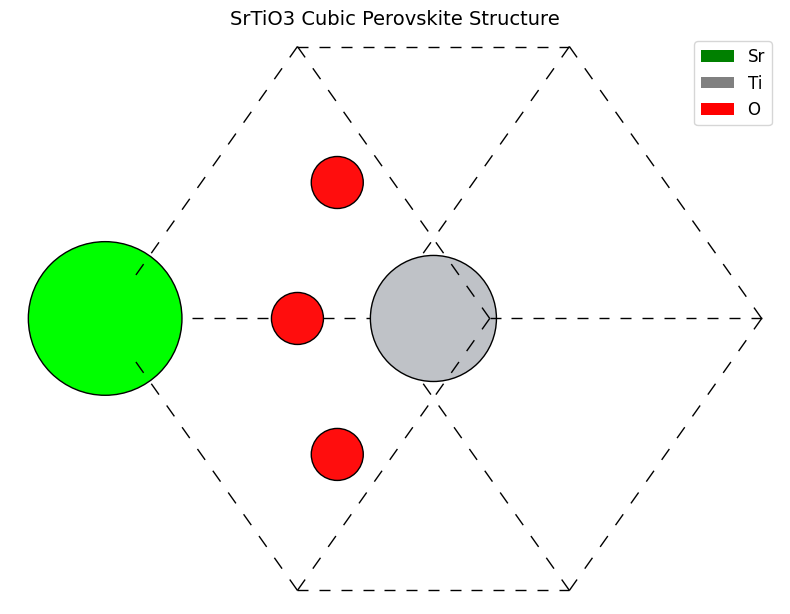


Figure saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/structures_from_databases/SrTiO3_structure.png


In [18]:
# Visualize the structure

fig, ax = plt.subplots(figsize=(8, 8))

# Use ASE's plot function
plot_atoms(srtio3, ax, radii=0.4, rotation=('45x,45y,0z'))

ax.set_title('SrTiO3 Cubic Perovskite Structure', fontsize=14)
ax.axis('off')

# Add legend
from matplotlib.patches import Circle
legend_elements = [
    Circle((0, 0), 0.1, facecolor='green', label='Sr'),
    Circle((0, 0), 0.1, facecolor='gray', label='Ti'),
    Circle((0, 0), 0.1, facecolor='red', label='O')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)

plt.tight_layout()
plt.savefig(str(WORK_DIR / 'SrTiO3_structure.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {WORK_DIR / 'SrTiO3_structure.png'}")

### Selecting the Most Reliable Structure

When multiple database entries exist, use this decision tree:

1. **Is the material experimentally known?**
   - Yes: Start with COD (experimental) structure, compare to DFT databases
   - No: Use Materials Project or AFLOW with lowest energy above hull

2. **Check stability metrics:**
   - Energy above hull should be 0 (or very small < 0.025 eV/atom)
   - No imaginary phonon frequencies (if available)

3. **Verify lattice parameters:**
   - Compare to experimental values (within ~1-2% for PBE)
   - Check if space group matches expected

4. **For the final calculation:**
   - Use experimental lattice parameters if comparing to experiment
   - OR relax with DFT if doing pure computational study

---

## 9. Structure File Formats

Understanding different file formats is essential for working with multiple codes.

### 9.1 CIF (Crystallographic Information File)

- Standard format for crystallographers
- Contains symmetry information
- Used by COD, ICSD, and most databases

In [19]:
# Write SrTiO3 in CIF format

cif_file = WORK_DIR / 'SrTiO3_ASE.cif'
write(str(cif_file), srtio3)

print("CIF Format Example (SrTiO3):")
print("=" * 60)
print(cif_file.read_text())

CIF Format Example (SrTiO3):
data_image0
_chemical_formula_structural       SrTiO3
_chemical_formula_sum              "Sr1 Ti1 O3"
_cell_length_a       3.905
_cell_length_b       3.905
_cell_length_c       3.905
_cell_angle_alpha    90.0
_cell_angle_beta     90.0
_cell_angle_gamma    90.0

_space_group_name_H-M_alt    "P 1"
_space_group_IT_number       1

loop_
  _space_group_symop_operation_xyz
  'x, y, z'

loop_
  _atom_site_type_symbol
  _atom_site_label
  _atom_site_symmetry_multiplicity
  _atom_site_fract_x
  _atom_site_fract_y
  _atom_site_fract_z
  _atom_site_occupancy
  Sr  Sr1       1.0  0.0  0.0  0.0  1.0000
  Ti  Ti1       1.0  0.49999999999999994  0.49999999999999994  0.49999999999999994  1.0000
  O   O1        1.0  0.49999999999999994  0.49999999999999994  0.0  1.0000
  O   O2        1.0  0.0  0.49999999999999994  0.49999999999999994  1.0000
  O   O3        1.0  0.49999999999999994  0.0  0.49999999999999994  1.0000



### 9.2 POSCAR (VASP Format)

- Used by VASP (Vienna Ab initio Simulation Package)
- Simple, widely understood format
- Two variants: Direct (fractional) and Cartesian coordinates

In [20]:
# Write SrTiO3 in POSCAR format

poscar_file = WORK_DIR / 'SrTiO3_POSCAR'
write(str(poscar_file), srtio3, format='vasp')

print("POSCAR Format Example (SrTiO3):")
print("=" * 60)
print(poscar_file.read_text())

print("\n--- Format Explanation ---")
print("Line 1: Comment (usually formula)")
print("Line 2: Universal scaling factor")
print("Lines 3-5: Lattice vectors (Angstrom)")
print("Line 6: Element symbols")
print("Line 7: Number of each element")
print("Line 8: 'Direct' (fractional) or 'Cartesian'")
print("Lines 9+: Atomic coordinates")

POSCAR Format Example (SrTiO3):
Sr Ti O 
 1.0000000000000000
     3.9049999999999998    0.0000000000000000    0.0000000000000000
     0.0000000000000000    3.9049999999999998    0.0000000000000000
     0.0000000000000000    0.0000000000000000    3.9049999999999998
 Sr  Ti  O  
   1   1   3
Cartesian
  0.0000000000000000  0.0000000000000000  0.0000000000000000
  1.9524999999999999  1.9524999999999999  1.9524999999999999
  1.9524999999999999  1.9524999999999999  0.0000000000000000
  0.0000000000000000  1.9524999999999999  1.9524999999999999
  1.9524999999999999  0.0000000000000000  1.9524999999999999


--- Format Explanation ---
Line 1: Comment (usually formula)
Line 2: Universal scaling factor
Lines 3-5: Lattice vectors (Angstrom)
Line 6: Element symbols
Line 7: Number of each element
Line 8: 'Direct' (fractional) or 'Cartesian'
Lines 9+: Atomic coordinates


### 9.3 Quantum ESPRESSO Format

QE has two main ways to specify positions:

1. **crystal**: Fractional coordinates (recommended)
2. **angstrom**: Cartesian in Angstrom
3. **bohr**: Cartesian in Bohr
4. **alat**: Cartesian in units of celldm(1)

In [21]:
def atoms_to_qe_input(atoms, pseudo_dir, prefix='material'):
    """
    Convert ASE Atoms object to Quantum ESPRESSO input format.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Structure to convert
    pseudo_dir : str
        Path to pseudopotential directory
    prefix : str
        Job prefix
    
    Returns
    -------
    str
        QE input file content (structure part)
    """
    cell = atoms.get_cell()
    positions = atoms.get_scaled_positions()
    symbols = atoms.get_chemical_symbols()
    unique_symbols = list(dict.fromkeys(symbols))  # Preserve order
    
    # Atomic masses (simplified)
    masses = {
        'H': 1.008, 'C': 12.011, 'N': 14.007, 'O': 15.999,
        'Sr': 87.62, 'Ti': 47.867, 'Ba': 137.327, 'Pb': 207.2,
        'Si': 28.0855, 'Ga': 69.723, 'As': 74.9216,
    }
    
    lines = []
    lines.append(f"&CONTROL")
    lines.append(f"    calculation = 'scf'")
    lines.append(f"    prefix = '{prefix}'")
    lines.append(f"    outdir = './tmp'")
    lines.append(f"    pseudo_dir = '{pseudo_dir}'")
    lines.append(f"/")
    lines.append(f"")
    lines.append(f"&SYSTEM")
    lines.append(f"    ibrav = 0")
    lines.append(f"    nat = {len(atoms)}")
    lines.append(f"    ntyp = {len(unique_symbols)}")
    lines.append(f"    ecutwfc = 50.0")
    lines.append(f"    ecutrho = 400.0")
    lines.append(f"/")
    lines.append(f"")
    lines.append(f"&ELECTRONS")
    lines.append(f"    conv_thr = 1.0e-8")
    lines.append(f"/")
    lines.append(f"")
    
    # CELL_PARAMETERS
    lines.append(f"CELL_PARAMETERS {{angstrom}}")
    for i in range(3):
        lines.append(f"  {cell[i, 0]:16.10f} {cell[i, 1]:16.10f} {cell[i, 2]:16.10f}")
    lines.append(f"")
    
    # ATOMIC_SPECIES
    lines.append(f"ATOMIC_SPECIES")
    for sym in unique_symbols:
        mass = masses.get(sym, 1.0)
        lines.append(f"  {sym}  {mass:.4f}  {sym}.upf")
    lines.append(f"")
    
    # ATOMIC_POSITIONS
    lines.append(f"ATOMIC_POSITIONS {{crystal}}")
    for sym, pos in zip(symbols, positions):
        lines.append(f"  {sym}  {pos[0]:16.10f} {pos[1]:16.10f} {pos[2]:16.10f}")
    lines.append(f"")
    
    # K_POINTS
    lines.append(f"K_POINTS {{automatic}}")
    lines.append(f"  6 6 6 0 0 0")
    
    return '\n'.join(lines)

# Generate QE input for SrTiO3
qe_input = atoms_to_qe_input(srtio3, '/path/to/pseudopotentials', prefix='srtio3')

print("Quantum ESPRESSO Input Format (SrTiO3):")
print("=" * 60)
print(qe_input)

# Save to file
qe_file = WORK_DIR / 'SrTiO3.pw.in'
qe_file.write_text(qe_input)
print(f"\nSaved to: {qe_file}")

Quantum ESPRESSO Input Format (SrTiO3):
&CONTROL
    calculation = 'scf'
    prefix = 'srtio3'
    outdir = './tmp'
    pseudo_dir = '/path/to/pseudopotentials'
/

&SYSTEM
    ibrav = 0
    nat = 5
    ntyp = 3
    ecutwfc = 50.0
    ecutrho = 400.0
/

&ELECTRONS
    conv_thr = 1.0e-8
/

CELL_PARAMETERS {angstrom}
      3.9050000000     0.0000000000     0.0000000000
      0.0000000000     3.9050000000     0.0000000000
      0.0000000000     0.0000000000     3.9050000000

ATOMIC_SPECIES
  Sr  87.6200  Sr.upf
  Ti  47.8670  Ti.upf
  O  15.9990  O.upf

ATOMIC_POSITIONS {crystal}
  Sr      0.0000000000     0.0000000000     0.0000000000
  Ti      0.5000000000     0.5000000000     0.5000000000
  O      0.5000000000     0.5000000000     0.0000000000
  O      0.0000000000     0.5000000000     0.5000000000
  O      0.5000000000     0.0000000000     0.5000000000

K_POINTS {automatic}
  6 6 6 0 0 0

Saved to: /home/niel/git/DFT_Tutorial/qe_workshop_complete/structures_from_databases/SrTiO3.pw.in


### 9.4 Converting Between Formats

ASE makes format conversion straightforward:

In [22]:
# Read from CIF, write to various formats

# Read the CIF file we downloaded from COD
atoms_from_cif = read(str(cif_path))

print(f"Read structure from: {cif_path}")
print(f"Formula: {atoms_from_cif.get_chemical_formula()}")
print(f"Number of atoms: {len(atoms_from_cif)}")

# Write to different formats (ASE-supported formats)
output_formats = {
    'POSCAR': ('vasp', WORK_DIR / 'structure_from_COD_POSCAR'),
    'XYZ': ('xyz', WORK_DIR / 'structure_from_COD.xyz'),
    'CIF': ('cif', WORK_DIR / 'structure_from_COD.cif'),
}

print("\nWriting to different formats:")
for format_name, (format_code, filepath) in output_formats.items():
    write(str(filepath), atoms_from_cif, format=format_code)
    print(f"  {format_name}: {filepath}")

Read structure from: /home/niel/git/DFT_Tutorial/qe_workshop_complete/structures_from_databases/SrTiO3_COD_1507756.cif
Formula: BaO3Ti
Number of atoms: 5

Writing to different formats:
  POSCAR: /home/niel/git/DFT_Tutorial/qe_workshop_complete/structures_from_databases/structure_from_COD_POSCAR
  XYZ: /home/niel/git/DFT_Tutorial/qe_workshop_complete/structures_from_databases/structure_from_COD.xyz
  CIF: /home/niel/git/DFT_Tutorial/qe_workshop_complete/structures_from_databases/structure_from_COD.cif


In [23]:
# Using pymatgen for more advanced conversions (if available)

pymatgen_example = """
# Install: pip install pymatgen

from pymatgen.core import Structure
from pymatgen.io.cif import CifParser
from pymatgen.io.vasp import Poscar
from pymatgen.io.pwscf import PWInput

# Read from CIF
parser = CifParser('SrTiO3.cif')
structure = parser.get_structures()[0]

# Write POSCAR
poscar = Poscar(structure)
poscar.write_file('POSCAR')

# Write QE input (basic)
pwinput = PWInput(
    structure,
    pseudo={'Sr': 'Sr.upf', 'Ti': 'Ti.upf', 'O': 'O.upf'},
    control={'calculation': 'scf'},
    system={'ecutwfc': 50},
    kpoints_grid=(6, 6, 6)
)
pwinput.write_file('srtio3.in')

# Access structure properties
print(f"Space group: {structure.get_space_group_info()}")
print(f"Lattice: {structure.lattice}")
"""

print("Pymatgen Conversion Example:")
print("=" * 50)
print(pymatgen_example)

Pymatgen Conversion Example:

# Install: pip install pymatgen

from pymatgen.core import Structure
from pymatgen.io.cif import CifParser
from pymatgen.io.vasp import Poscar
from pymatgen.io.pwscf import PWInput

# Read from CIF
parser = CifParser('SrTiO3.cif')
structure = parser.get_structures()[0]

# Write POSCAR
poscar = Poscar(structure)
poscar.write_file('POSCAR')

# Write QE input (basic)
pwinput = PWInput(
    structure,
    pseudo={'Sr': 'Sr.upf', 'Ti': 'Ti.upf', 'O': 'O.upf'},
    control={'calculation': 'scf'},
    system={'ecutwfc': 50},
    kpoints_grid=(6, 6, 6)
)
pwinput.write_file('srtio3.in')

# Access structure properties
print(f"Space group: {structure.get_space_group_info()}")
print(f"Lattice: {structure.lattice}")



---

## 10. Red Flags to Watch For

When selecting structures from databases, watch out for these issues:

In [24]:
red_flags = """
RED FLAGS IN DATABASE STRUCTURES
=================================

1. METASTABLE PHASES
   - Energy above hull > 0.050 eV/atom
   - May not be experimentally accessible
   - Always check: Is there a more stable polymorph?
   
2. HIGH ENERGY STRUCTURES
   - Formation energy less negative than expected
   - Could indicate: wrong structure, unconverged calculation
   - Compare to similar materials
   
3. PARTIAL OCCUPANCIES
   - CIF files may have sites with occupancy < 1.0
   - Example: "Fe 0.0 0.0 0.0 0.75" means 75% Fe occupancy
   - DFT cannot handle this directly!
   - Solutions: Use SQS, VCA, or ordered supercell
   
4. DISORDERED STRUCTURES
   - Mixed occupancy on same site (e.g., Fe/Ni alloy)
   - Amorphous or glass-like disorder
   - Need special treatment for DFT
   
5. WRONG SPACE GROUP
   - Some databases use relaxed (lower symmetry) structures
   - Experimental structures may have different symmetry at different T
   - Always verify the space group matches your expectation
   
6. UNREALISTIC BOND LENGTHS
   - Atoms too close together (< 1.5 Angstrom for most elements)
   - Atoms too far apart (missing atoms?)
   - Check against typical bond lengths
   
7. MISSING ATOMS
   - Hydrogen atoms often missing from X-ray structures
   - Light elements may be absent or misplaced
   - Always check stoichiometry
   
8. SUPERCELL vs PRIMITIVE CELL
   - Some databases give supercells
   - May need to reduce to primitive cell for efficiency
   - Use spglib or pymatgen to standardize

VALIDATION CHECKLIST:
[ ] Formation energy is reasonable (compare to similar materials)
[ ] Energy above hull is 0 or very small
[ ] Lattice parameters match experiment within 1-2%
[ ] Space group is correct
[ ] All sites have full occupancy
[ ] Bond lengths are physically reasonable
[ ] Stoichiometry is correct
"""

print(red_flags)


RED FLAGS IN DATABASE STRUCTURES

1. METASTABLE PHASES
   - Energy above hull > 0.050 eV/atom
   - May not be experimentally accessible
   - Always check: Is there a more stable polymorph?
   
2. HIGH ENERGY STRUCTURES
   - Formation energy less negative than expected
   - Could indicate: wrong structure, unconverged calculation
   - Compare to similar materials
   
3. PARTIAL OCCUPANCIES
   - CIF files may have sites with occupancy < 1.0
   - Example: "Fe 0.0 0.0 0.0 0.75" means 75% Fe occupancy
   - DFT cannot handle this directly!
   - Solutions: Use SQS, VCA, or ordered supercell
   
4. DISORDERED STRUCTURES
   - Mixed occupancy on same site (e.g., Fe/Ni alloy)
   - Amorphous or glass-like disorder
   - Need special treatment for DFT
   
5. WRONG SPACE GROUP
   - Some databases use relaxed (lower symmetry) structures
   - Experimental structures may have different symmetry at different T
   - Always verify the space group matches your expectation
   
6. UNREALISTIC BOND LENGTHS
  

In [25]:
def validate_structure(atoms):
    """
    Basic validation of a crystal structure.
    
    Parameters
    ----------
    atoms : ase.Atoms
        Structure to validate
    
    Returns
    -------
    dict
        Validation results
    """
    from ase.neighborlist import neighbor_list
    
    results = {
        'formula': atoms.get_chemical_formula(),
        'n_atoms': len(atoms),
        'issues': []
    }
    
    # Get minimum distance using neighbor list (more robust)
    # Find all pairs within 5 Angstrom
    i, j, d = neighbor_list('ijd', atoms, cutoff=5.0)
    
    if len(d) > 0:
        min_dist = np.min(d)
    else:
        min_dist = 0.0
    
    results['min_distance'] = min_dist
    
    if min_dist < 1.0:
        results['issues'].append(f"WARNING: Very short bond ({min_dist:.2f} Angstrom)")
    elif min_dist < 1.5:
        results['issues'].append(f"CAUTION: Short bond ({min_dist:.2f} Angstrom) - check if reasonable")
    
    # Check cell vectors
    cell_lengths = atoms.cell.lengths()
    cell_angles = atoms.cell.angles()
    
    results['cell_lengths'] = cell_lengths
    results['cell_angles'] = cell_angles
    
    for i, length in enumerate(cell_lengths):
        if length < 2.0:
            results['issues'].append(f"WARNING: Very small cell dimension ({length:.2f} Angstrom)")
    
    # Check volume per atom
    vol_per_atom = atoms.get_volume() / len(atoms)
    results['volume_per_atom'] = vol_per_atom
    
    if vol_per_atom < 5:
        results['issues'].append(f"WARNING: Very small volume per atom ({vol_per_atom:.1f} Angstrom^3)")
    elif vol_per_atom > 100:
        results['issues'].append(f"CAUTION: Large volume per atom ({vol_per_atom:.1f} Angstrom^3) - porous structure?")
    
    return results

# Validate our SrTiO3 structure
validation = validate_structure(srtio3)

print("Structure Validation Report")
print("=" * 50)
print(f"Formula: {validation['formula']}")
print(f"Number of atoms: {validation['n_atoms']}")
print(f"Minimum interatomic distance: {validation['min_distance']:.3f} Angstrom")
print(f"Volume per atom: {validation['volume_per_atom']:.2f} Angstrom^3")
print(f"\nCell lengths: {validation['cell_lengths']}")
print(f"Cell angles: {validation['cell_angles']}")

if validation['issues']:
    print("\nIssues found:")
    for issue in validation['issues']:
        print(f"  {issue}")
else:
    print("\nNo issues found. Structure looks reasonable.")

Structure Validation Report
Formula: O3SrTi
Number of atoms: 5
Minimum interatomic distance: 1.952 Angstrom
Volume per atom: 11.91 Angstrom^3

Cell lengths: [3.905 3.905 3.905]
Cell angles: [90. 90. 90.]

No issues found. Structure looks reasonable.


---

## 11. HANDS-ON: Complete Database → DFT Workflow

**This is where theory becomes practice!**

In this section, we will:
1. Search a database for a real material
2. Download and validate the structure
3. Set up pseudopotentials automatically
4. Generate a complete QE input file
5. Run a quick SCF calculation to verify everything works

This is the workflow you will use for EVERY material in your research.

In [26]:
# =============================================================================
# HANDS-ON: Import workshop utilities for REAL DFT calculations
# =============================================================================
import sys
from pathlib import Path

# Add workshop setup to path
_cwd = Path.cwd().resolve()
if (_cwd / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd))
elif (_cwd / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd / 'notebooks_enhanced'))
elif (_cwd.parent / 'notebooks_enhanced' / 'workshop_setup.py').exists():
    sys.path.insert(0, str(_cwd.parent / 'notebooks_enhanced'))

from workshop_setup import *

print_workshop_banner()
verify_qe_installation()

QUANTUM ESPRESSO WORKSHOP - SETUP

Paths:
  Workshop root:     /home/niel/git/DFT_Tutorial/qe_workshop_complete
  Pseudopotentials:  /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials
  Output directory:  /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs

QE Executables:
  pw.x:    /home/niel/src/qe-7.5/bin/pw.x
  MPI:     /usr/bin/mpirun
  NPROCS:  4

Available functionals: PBE, LDA, PBEsol
Elements in database: PBE(70), LDA(34), PBEsol(38)
VERIFYING QUANTUM ESPRESSO INSTALLATION
  ✓ pw.x found: /home/niel/src/qe-7.5/bin/pw.x
  ✓ MPI found: /usr/bin/mpirun


  ✓ Version: Program PWSCF v.7.5 starts on  4Feb2026 at 19:15:23


True

In [27]:
# =============================================================================
# HANDS-ON EXERCISE: Database → DFT for a REAL Material
# =============================================================================
# Let's work through a complete example with Copper (Cu) - an FCC metal
# 
# >>> STUDENT: You can change this to ANY material you're interested in! <<<
# =============================================================================

from ase.spacegroup import crystal
from ase.io.espresso import write_espresso_in
from datetime import datetime

# -----------------------------------------------------------------------------
# STEP 1: Define your material (from database research)
# -----------------------------------------------------------------------------
# Cu FCC - experimental data from COD/literature
# Space group: Fm-3m (225)
# Lattice parameter: a = 3.615 Å (experimental at 298 K)

MATERIAL_NAME = "Cu"
SPACE_GROUP = 225  # Fm-3m (FCC)
LATTICE_A = 3.615  # Angstrom (experimental)

# Create structure using crystallographic data
cu_atoms = crystal(
    symbols=['Cu'],
    basis=[(0.0, 0.0, 0.0)],  # FCC has Cu at corners and face centers
    spacegroup=SPACE_GROUP,
    cellpar=[LATTICE_A, LATTICE_A, LATTICE_A, 90, 90, 90]
)

print(f"Created {MATERIAL_NAME} structure from crystallographic data")
print(f"=" * 60)
print(f"Formula: {cu_atoms.get_chemical_formula()}")
print(f"Space group: {SPACE_GROUP} (Fm-3m)")
print(f"Lattice parameter: {LATTICE_A} Å")
print(f"Number of atoms in primitive cell: {len(cu_atoms)}")
print(f"Volume: {cu_atoms.get_volume():.3f} Å³")
print(f"\nAtomic positions (fractional):")
for i, (sym, pos) in enumerate(zip(cu_atoms.get_chemical_symbols(), 
                                    cu_atoms.get_scaled_positions())):
    print(f"  {sym}: ({pos[0]:.4f}, {pos[1]:.4f}, {pos[2]:.4f})")

Created Cu structure from crystallographic data
Formula: Cu4
Space group: 225 (Fm-3m)
Lattice parameter: 3.615 Å
Number of atoms in primitive cell: 4
Volume: 47.242 Å³

Atomic positions (fractional):
  Cu: (0.0000, 0.0000, 0.0000)
  Cu: (0.0000, 0.5000, 0.5000)
  Cu: (0.5000, 0.0000, 0.5000)
  Cu: (0.5000, 0.5000, 0.0000)


In [28]:
# -----------------------------------------------------------------------------
# STEP 2: Validate the structure before DFT
# -----------------------------------------------------------------------------
from ase.neighborlist import neighbor_list

def comprehensive_validation(atoms, material_name):
    """Comprehensive structure validation with visual report."""
    print(f"\n{'='*60}")
    print(f"STRUCTURE VALIDATION: {material_name}")
    print(f"{'='*60}")
    
    issues = []
    
    # 1. Formula and basic info
    print(f"\n1. Basic Information:")
    print(f"   Formula: {atoms.get_chemical_formula()}")
    print(f"   N atoms: {len(atoms)}")
    print(f"   Volume: {atoms.get_volume():.3f} Å³")
    
    # 2. Cell parameters
    print(f"\n2. Cell Parameters:")
    lengths = atoms.cell.lengths()
    angles = atoms.cell.angles()
    print(f"   a = {lengths[0]:.4f} Å")
    print(f"   b = {lengths[1]:.4f} Å")
    print(f"   c = {lengths[2]:.4f} Å")
    print(f"   α = {angles[0]:.2f}°, β = {angles[1]:.2f}°, γ = {angles[2]:.2f}°")
    
    # 3. Interatomic distances
    print(f"\n3. Bond Analysis:")
    i_idx, j_idx, d = neighbor_list('ijd', atoms, cutoff=5.0)
    if len(d) > 0:
        min_dist = np.min(d)
        mean_dist = np.mean(d[d < 3.5])  # First shell
        print(f"   Minimum distance: {min_dist:.3f} Å")
        print(f"   Mean nearest-neighbor: {mean_dist:.3f} Å")
        
        if min_dist < 1.5:
            issues.append(f"⚠ Very short bond: {min_dist:.2f} Å")
    
    # 4. Volume per atom
    vol_per_atom = atoms.get_volume() / len(atoms)
    print(f"\n4. Volume per atom: {vol_per_atom:.2f} Å³")
    if vol_per_atom < 8:
        issues.append(f"⚠ Small volume per atom: {vol_per_atom:.1f} Å³")
    
    # 5. Summary
    print(f"\n{'='*60}")
    if issues:
        print("ISSUES FOUND:")
        for issue in issues:
            print(f"   {issue}")
    else:
        print("✓ ALL CHECKS PASSED - Structure is valid for DFT!")
    print(f"{'='*60}")
    
    return len(issues) == 0

# Validate our Cu structure
is_valid = comprehensive_validation(cu_atoms, MATERIAL_NAME)


STRUCTURE VALIDATION: Cu

1. Basic Information:
   Formula: Cu4
   N atoms: 4
   Volume: 47.242 Å³

2. Cell Parameters:
   a = 3.6150 Å
   b = 3.6150 Å
   c = 3.6150 Å
   α = 90.00°, β = 90.00°, γ = 90.00°

3. Bond Analysis:
   Minimum distance: 2.556 Å
   Mean nearest-neighbor: 2.556 Å

4. Volume per atom: 11.81 Å³

✓ ALL CHECKS PASSED - Structure is valid for DFT!


In [29]:
# -----------------------------------------------------------------------------
# STEP 3: Setup pseudopotentials (automatic download!)
# -----------------------------------------------------------------------------
elements = list(set(cu_atoms.get_chemical_symbols()))
print(f"Elements in structure: {elements}")

# This automatically downloads the right pseudopotentials!
pp_files = setup_pseudopotentials(elements, functional='PBE')

# Get recommended cutoffs from SSSP database
ecutwfc, ecutrho = get_recommended_cutoffs(elements, 'PBE')
print(f"\nSSP Recommended cutoffs:")
print(f"  ecutwfc = {ecutwfc} Ry")
print(f"  ecutrho = {ecutrho} Ry")

Elements in structure: ['Cu']
PSEUDOPOTENTIAL SETUP - PBE
  ✓ Cu: Cu.pbe-dn-kjpaw_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE

SSP Recommended cutoffs:
  ecutwfc = 55 Ry
  ecutrho = 440 Ry


In [30]:
# -----------------------------------------------------------------------------
# STEP 4: Create working directory and QE input file
# -----------------------------------------------------------------------------

# Create a unique directory for this calculation (no overwrites!)
calc_dir = OUTPUT_DIR / f'01_handson_{MATERIAL_NAME}_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
calc_dir.mkdir(parents=True, exist_ok=True)
(calc_dir / 'tmp').mkdir(exist_ok=True)

print(f"Calculation directory: {calc_dir}")

# Generate QE input using ASE
prefix = MATERIAL_NAME.lower() + '_scf'
input_file = calc_dir / f'{prefix}.in'

pseudopotentials = {elem: get_pseudopotential_filename(elem, 'PBE') for elem in elements}

input_data = {
    'control': {
        'calculation': 'scf',
        'prefix': prefix,
        'outdir': './tmp',
        'pseudo_dir': str(get_pseudo_dir('PBE')),
        'tprnfor': True,
        'tstress': True,
        'verbosity': 'high',
    },
    'system': {
        'ecutwfc': ecutwfc,
        'ecutrho': ecutrho,
        'occupations': 'smearing',
        'smearing': 'mv',  # Marzari-Vanderbilt cold smearing (good for metals)
        'degauss': 0.02,
    },
    'electrons': {
        'conv_thr': 1.0e-8,
        'mixing_beta': 0.3,
    },
}

# Write the input file
write_espresso_in(input_file, cu_atoms, input_data=input_data, 
                  pseudopotentials=pseudopotentials, kpts=(8, 8, 8))

print(f"\nQE input file created: {input_file}")
print(f"\n{'='*60}")
print("INPUT FILE CONTENTS:")
print(f"{'='*60}")
print(input_file.read_text())

Calculation directory: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/01_handson_Cu_20260204_191523

QE input file created: /home/niel/git/DFT_Tutorial/qe_workshop_complete/outputs/01_handson_Cu_20260204_191523/cu_scf.in

INPUT FILE CONTENTS:
&CONTROL
   calculation      = 'scf'
   verbosity        = 'high'
   tstress          = .true.
   tprnfor          = .true.
   outdir           = './tmp'
   prefix           = 'cu_scf'
   pseudo_dir       = '/home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE'
/
&SYSTEM
   ecutwfc          = 55
   ecutrho          = 440
   occupations      = 'smearing'
   degauss          = 0.02
   smearing         = 'mv'
   ntyp             = 1
   nat              = 4
   ibrav            = 0
/
&ELECTRONS
   conv_thr         = 1e-08
   mixing_beta      = 0.3
/
&IONS
/
&CELL
/
&FCP
/
&RISM
/
ATOMIC_SPECIES
Cu 63.546 Cu.pbe-dn-kjpaw_psl.1.0.0.UPF

K_POINTS automatic
8 8 8  0 0 0

CELL_PARAMETERS angstrom
3.61500000000000 0.00000000000000 

In [31]:
# -----------------------------------------------------------------------------
# STEP 5: RUN THE DFT CALCULATION!
# -----------------------------------------------------------------------------
# This is the moment of truth - let's run a real QE calculation

print(f"Running SCF calculation for {MATERIAL_NAME}...")
print(f"Using {NPROCS} MPI processes")
print(f"This may take a few minutes...\n")

output, elapsed, converged = run_qe(input_file, nprocs=NPROCS, timeout=1800)

# Parse results
results = parse_qe_output(output)

print(f"\n{'='*60}")
print(f"CALCULATION RESULTS: {MATERIAL_NAME}")
print(f"{'='*60}")
print(f"Converged: {'✓ YES' if converged else '✗ NO'}")
print(f"Wall time: {elapsed:.1f} seconds")

if results['total_energy_ev']:
    print(f"\nTotal energy: {results['total_energy_ev']:.6f} eV")
    print(f"Energy per atom: {results['total_energy_ev']/len(cu_atoms):.6f} eV/atom")

if results['pressure_kbar']:
    print(f"Pressure: {results['pressure_kbar']:.2f} kbar")
    # Positive pressure means cell is too small, negative means too large
    if abs(results['pressure_kbar']) < 5:
        print("  → Cell is well equilibrated!")
    elif results['pressure_kbar'] > 0:
        print("  → Hint: Positive pressure suggests cell is too small")
    else:
        print("  → Hint: Negative pressure suggests cell is too large")

if results['fermi_energy_ev']:
    print(f"Fermi energy: {results['fermi_energy_ev']:.4f} eV")

print(f"\n{'='*60}")
print("Congratulations! You've completed your first database → DFT workflow!")
print(f"{'='*60}")

Running SCF calculation for Cu...
Using 4 MPI processes
This may take a few minutes...

Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in cu_scf.in


  ✓ Converged in 147.2s

CALCULATION RESULTS: Cu
Converged: ✓ YES
Wall time: 147.2 seconds

Total energy: -11597.299315 eV
Energy per atom: -2899.324829 eV/atom
Pressure: 16.08 kbar
  → Hint: Positive pressure suggests cell is too small
Fermi energy: 12.6696 eV

Congratulations! You've completed your first database → DFT workflow!


---

## 12. STUDENT EXERCISE: Try Your Own Material!

Now it's your turn! Modify the cell below to calculate a different material.

**Suggestions:**
- **Al (FCC)**: a = 4.05 Å, space group 225
- **Fe (BCC)**: a = 2.87 Å, space group 229 (magnetic!)
- **NaCl (rocksalt)**: a = 5.64 Å, space group 225
- **MgO (rocksalt)**: a = 4.21 Å, space group 225
- **GaAs (zincblende)**: a = 5.65 Å, space group 216

**What to observe:**
1. How does the energy per atom compare between materials?
2. Is the pressure close to zero? (indicates good lattice parameter)
3. For metals: check the Fermi energy
4. For semiconductors/insulators: check if a band gap is reported

In [32]:
# =============================================================================
# >>> STUDENT EXERCISE: Modify this cell for YOUR material! <<<
# =============================================================================

# CHANGE THESE VALUES FOR YOUR MATERIAL
MY_MATERIAL = "Al"           # Element symbol or compound name
MY_LATTICE_A = 4.05          # Lattice parameter in Angstrom
MY_SPACE_GROUP = 225         # Space group number
MY_BASIS = [(0.0, 0.0, 0.0)] # Wyckoff positions

# For compounds, you need multiple elements and positions:
# Example for NaCl:
# MY_MATERIAL = "NaCl"
# MY_LATTICE_A = 5.64
# MY_SPACE_GROUP = 225
# MY_BASIS = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5)]  # Na at origin, Cl at body center
# symbols = ['Na', 'Cl']

# -----------------------------------------------------------------------------
# The code below will run your calculation - no need to modify!
# -----------------------------------------------------------------------------

# Create structure
if '-' in MY_MATERIAL or len(MY_MATERIAL) > 3:
    # Compound - need to define symbols separately
    print("For compounds, define 'symbols' list above matching MY_BASIS positions")
else:
    symbols = [MY_MATERIAL]

my_atoms = crystal(
    symbols=symbols,
    basis=MY_BASIS,
    spacegroup=MY_SPACE_GROUP,
    cellpar=[MY_LATTICE_A, MY_LATTICE_A, MY_LATTICE_A, 90, 90, 90]
)

# Validate
print(f"Structure created: {my_atoms.get_chemical_formula()}")
is_valid = comprehensive_validation(my_atoms, MY_MATERIAL)

if is_valid:
    # Setup and run
    my_elements = list(set(my_atoms.get_chemical_symbols()))
    my_pp = setup_pseudopotentials(my_elements, functional='PBE')
    my_ecutwfc, my_ecutrho = get_recommended_cutoffs(my_elements, 'PBE')
    
    # Create calculation directory
    my_calc_dir = OUTPUT_DIR / f'01_student_{MY_MATERIAL}_{datetime.now().strftime("%H%M%S")}'
    my_calc_dir.mkdir(parents=True, exist_ok=True)
    (my_calc_dir / 'tmp').mkdir(exist_ok=True)
    
    my_prefix = MY_MATERIAL.lower().replace(' ', '_') + '_scf'
    my_input_file = my_calc_dir / f'{my_prefix}.in'
    
    my_pseudopotentials = {elem: get_pseudopotential_filename(elem, 'PBE') for elem in my_elements}
    my_input_data = {
        'control': {'calculation': 'scf', 'prefix': my_prefix, 'outdir': './tmp',
                   'pseudo_dir': str(get_pseudo_dir('PBE')), 'tprnfor': True, 'tstress': True},
        'system': {'ecutwfc': my_ecutwfc, 'ecutrho': my_ecutrho,
                  'occupations': 'smearing', 'smearing': 'mv', 'degauss': 0.02},
        'electrons': {'conv_thr': 1.0e-8},
    }
    
    write_espresso_in(my_input_file, my_atoms, input_data=my_input_data, 
                      pseudopotentials=my_pseudopotentials, kpts=(8, 8, 8))
    
    print(f"\nRunning calculation for {MY_MATERIAL}...")
    my_output, my_elapsed, my_converged = run_qe(my_input_file, nprocs=NPROCS, timeout=1800)
    my_results = parse_qe_output(my_output)
    
    print(f"\n{'='*50}")
    print(f"YOUR RESULTS: {MY_MATERIAL}")
    print(f"{'='*50}")
    print(f"Converged: {'✓' if my_converged else '✗'}")
    if my_results['total_energy_ev']:
        print(f"Energy: {my_results['total_energy_ev']:.6f} eV")
        print(f"Energy/atom: {my_results['total_energy_ev']/len(my_atoms):.6f} eV/atom")
    if my_results['pressure_kbar']:
        print(f"Pressure: {my_results['pressure_kbar']:.2f} kbar")

Structure created: Al4

STRUCTURE VALIDATION: Al

1. Basic Information:
   Formula: Al4
   N atoms: 4
   Volume: 66.430 Å³

2. Cell Parameters:
   a = 4.0500 Å
   b = 4.0500 Å
   c = 4.0500 Å
   α = 90.00°, β = 90.00°, γ = 90.00°

3. Bond Analysis:
   Minimum distance: 2.864 Å
   Mean nearest-neighbor: 2.864 Å

4. Volume per atom: 16.61 Å³

✓ ALL CHECKS PASSED - Structure is valid for DFT!
PSEUDOPOTENTIAL SETUP - PBE
  ✓ Al: Al.pbe-nl-kjpaw_psl.1.0.0.UPF
Pseudopotentials ready in: /home/niel/git/DFT_Tutorial/qe_workshop_complete/pseudopotentials/PBE

Running calculation for Al...
Running: /usr/bin/mpirun -np 4 /home/niel/src/qe-7.5/bin/pw.x -in al_scf.in


  ✓ Converged in 30.9s

YOUR RESULTS: Al
Converged: ✓
Energy: -2149.857331 eV
Energy/atom: -537.464333 eV/atom
Pressure: -3.78 kbar


---

## 11. Summary and Best Practices

### Key Takeaways

1. **Always start with database structures** - never guess atomic positions

2. **Use multiple databases** to cross-validate:
   - Materials Project for comprehensive DFT data
   - AFLOW for prototypes and high-throughput results
   - COD for experimental structures
   - OQMD for formation energies

3. **Check stability before calculating**:
   - Energy above hull should be 0 (or < 0.025 eV/atom)
   - Compare formation energy to similar materials

4. **Verify against experiment**:
   - Lattice parameters within 1-2% of experiment for PBE
   - Correct space group
   - Reasonable bond lengths

5. **Watch for red flags**:
   - Partial occupancies
   - Disordered structures
   - Metastable phases
   - Missing atoms

In [33]:
# Database Quick Reference

database_reference = """
DATABASE QUICK REFERENCE
========================

Materials Project (https://materialsproject.org)
  - ID format: mp-XXXXX
  - API: mp-api Python package
  - Best for: DFT properties, stability, phase diagrams
  - Note: Requires free API key

AFLOW (http://aflowlib.org)
  - ID format: aflow:XXXXXXXXX (AUID)
  - API: REST (AFLUX query language)
  - Best for: Prototypes, high-throughput, symmetry analysis
  - Note: No API key required

OQMD (http://oqmd.org)
  - ID format: entry_id (integer)
  - API: REST, qmpy Python package
  - Best for: Formation energies, phase stability
  - Note: No API key required

COD (http://crystallography.net/cod)
  - ID format: COD ID (integer)
  - API: REST, direct CIF download
  - Best for: Experimental structures
  - Note: Free access, no API key

JARVIS (https://jarvis.nist.gov)
  - ID format: JVASP-XXXXX (jid)
  - API: jarvis-tools Python package
  - Best for: 2D materials, ML properties
  - Note: Free dataset download

ICSD (https://icsd.fiz-karlsruhe.de) [Subscription]
  - ID format: ICSD Collection Code
  - Best for: Comprehensive experimental structures
  - Note: Requires institutional subscription
"""

print(database_reference)


DATABASE QUICK REFERENCE

Materials Project (https://materialsproject.org)
  - ID format: mp-XXXXX
  - API: mp-api Python package
  - Best for: DFT properties, stability, phase diagrams
  - Note: Requires free API key

AFLOW (http://aflowlib.org)
  - ID format: aflow:XXXXXXXXX (AUID)
  - API: REST (AFLUX query language)
  - Best for: Prototypes, high-throughput, symmetry analysis
  - Note: No API key required

OQMD (http://oqmd.org)
  - ID format: entry_id (integer)
  - API: REST, qmpy Python package
  - Best for: Formation energies, phase stability
  - Note: No API key required

COD (http://crystallography.net/cod)
  - ID format: COD ID (integer)
  - API: REST, direct CIF download
  - Best for: Experimental structures
  - Note: Free access, no API key

JARVIS (https://jarvis.nist.gov)
  - ID format: JVASP-XXXXX (jid)
  - API: jarvis-tools Python package
  - Best for: 2D materials, ML properties
  - Note: Free dataset download

ICSD (https://icsd.fiz-karlsruhe.de) [Subscription]
  - I

### Next Steps

Now that you have a validated structure from a reliable database, you can proceed to:

1. **Download pseudopotentials** for your elements
2. **Prepare the input file** for Quantum ESPRESSO
3. **Perform convergence tests** (ecutwfc, k-points)
4. **Relax the structure** if needed
5. **Calculate properties** (band structure, DOS, etc.)

---

**Remember**: The time spent finding and validating structures saves hours of wasted calculations later!

In [34]:
# List all files we created in this notebook

print("Files created in this notebook:")
print("=" * 50)

for filepath in sorted(WORK_DIR.glob('*')):
    size_kb = filepath.stat().st_size / 1024
    print(f"  {filepath.name:40s} ({size_kb:.1f} KB)")

Files created in this notebook:
  SrTiO3.pw.in                             (0.8 KB)
  SrTiO3_ASE.cif                           (0.9 KB)
  SrTiO3_COD_1507756.cif                   (2.5 KB)
  SrTiO3_POSCAR                            (0.6 KB)
  SrTiO3_from_COD.xyz                      (0.4 KB)
  SrTiO3_from_COD_POSCAR                   (0.6 KB)
  SrTiO3_structure.png                     (75.1 KB)
  structure_from_COD.cif                   (0.8 KB)
  structure_from_COD.xyz                   (0.4 KB)
  structure_from_COD_POSCAR                (0.6 KB)
